# Mont Carlo Integration

In [90]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd

## Example 1. 
f(x) = x**2 
<br>on [0,1]

__Analytical__

In [2]:
def f(x):
    return x**2

In [3]:
def F(a_in, b_in):
    return 1/3 * b**3 - 1/3 * a**3

In [4]:
a = 0
b = 1
F(a_in = a, b_in = b)

0.3333333333333333

### Monte Carlo
https://theclevermachine.wordpress.com/tag/monte-carlo-integration/

In [6]:
num_iters = 500000
np.mean(f(scipy.stats.uniform.rvs(loc = a, scale = b, size = num_iters, random_state = 1)))

0.3331020892340764

## Example 1b.
Add a normalization factor for the uniform distribution.
<br>on [0,2]

In [7]:
a = 0
b = 2
F(a_in = a, b_in = b)

2.6666666666666665

### Monte Carlo

In [8]:
num_iters = 5000000
p_x_norm_factor = b - a

out = scipy.stats.uniform.rvs(loc = a, scale = b, size = num_iters, random_state = 1)
out = f(out)
out = np.mean(out)
p_x_norm_factor * out

2.6665476169389173

## Example 2. Normal distribution
on [1, 1000]

__Quick compare: two different methods to calculate norm pdf__

In [9]:
def f(x, mu = 0, sd = 1):
    out = x - mu
    out = mu**2
    out = -1 * out / (2 * sd**2)
    out = np.exp(out)   
    return 1/(np.sqrt(2 * np.pi * sd**2)) * out 

f(x = 0, sd = 1, mu = 0)

0.3989422804014327

In [10]:
def f(x, mu = 0, sd = 1):
    return scipy.stats.norm.pdf(x = x, loc = mu, scale = sd)
    
f(x = 0, sd = 1, mu = 0)

0.3989422804014327

__So scipy.stats works as expected__

__Define integral__

In [15]:
def F(a_in, b_in, mu = 0, sd = 1):
    return scipy.stats.norm.cdf(x = b_in, loc = mu, scale = sd) - scipy.stats.norm.cdf(x = a_in, loc = mu, scale = sd)

__Double-check that scipy.stats.cdf works as expected:__

In [16]:
a = 0
b = 1000
F(0, 1000)

0.5

### Monte Carlo

In [17]:
num_iters = 50000000
p_x_norm_factor = b - a

out = scipy.stats.uniform.rvs(loc = a, scale = b, size = num_iters, random_state = 1)
out = f(out)
out = np.mean(out)
p_x_norm_factor * out

0.4985915822663913

__So Monte Carlo successfully recreates analytical cdf__

## MCMC Integration
__As per__
<br>https://stats.stackexchange.com/questions/248652/approximating-1d-integral-with-metropolis-hastings-markov-chain-monte-carlo

__Other material__
<br>https://stats.stackexchange.com/questions/154409/metropolis-hastings-integration-why-isnt-my-strategy-working
<br>https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm

In [18]:
def f(x, a, b):
    if a <= x <= b:
        return x**2
    else:
        return 0

In [29]:
def F(a_in, b_in):
    return 1/3 * b**3 - 1/3 * a**3

In [121]:
a = 0
b = 3

num_iters = 4000 #number of iterations
sigma = 0.5

x = scipy.stats.uniform.rvs(loc = a, scale = b, size = 1, random_state = 1)[0] #initial x value

chain = [] #stores Markov chain 
chain.append(f(x, a, b)) #initialises chain

accept = 0 # number of accepted jumps

#generates an array of random x values from norm distribution
rands = scipy.stats.norm.rvs(loc = 0, scale = sigma, size = num_iters) 
rands_u = scipy.stats.uniform.rvs(loc = 0, scale = 1, size = num_iters) #rand number between 0 and 1

### Random-walk MCMC. (Not Metropolis - Hastings algorithm)
for i in range(1, num_iters):
    x += rands[i]  #candidate for jump
    if f(x, a, b) > 0:
        chain.append(f(x, a, b))

I = (b - a) * np.mean(chain) #integral approximation


### uncertainty on approx.
uncertainty = (b - a) / np.sqrt(len(chain)) * np.std(chain) 

### integral approx at each iteration
conv = np.array([(b - a)*sum(chain[:x+1])*(1/(x+1)) for x in range(len(chain))])

#chain
print("analytical answer", F(a, b))
print("number accepted jumps", accept)
print('MCMC approx: ', I, '\t','uncertainty: ', uncertainty)

analytical answer 9.0
number accepted jumps 0
MCMC approx:  9.089915341334532 	 uncertainty:  0.38774188255097475


__Avg from MCMC is low.__
<br>Perhaps sampling still not uniform?
<br>Uniform would generate and integral of 0.5 on the cdf.

In [122]:
MCMC_cdf = pd.DataFrame({"x": np.sort(chain),
                         "y": np.arange(len(chain)) / len(chain)})
MCMC_cdf['ideal_y'] = 1 / (np.max(MCMC_cdf['x']) - np.min(MCMC_cdf['x'])) * (MCMC_cdf['x'] - np.min(MCMC_cdf['x']))
MCMC_cdf.head()

,x,y,ideal_y
0,0.000342,0.000000,0.000000
1,0.000411,0.002469,0.000008
2,0.000554,0.004938,0.000024
3,0.001206,0.007407,0.000096
4,0.004280,0.009877,0.000438


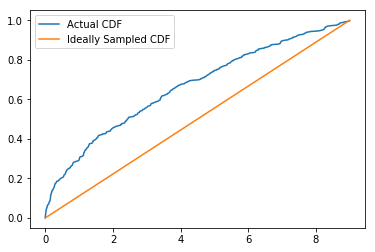

In [123]:
plt.plot(MCMC_cdf['x'],
         MCMC_cdf['y'],
        label = "Actual CDF")
plt.plot(MCMC_cdf['x'],
         MCMC_cdf['ideal_y'],
        label = "Ideally Sampled CDF")
plt.legend()